In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import data_retrieval.psql_methods as psql
import pandas as pd
import snob_utils as snob
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import statistics
img_path  = 'snob_case_study'
feat_path = 'snob_case_study_features'

In [ ]:
command = "SELECT * from collection_total_stats"
temp_stats_tuples = psql.execute_commands([command])
columns = ['volume','sales', 'avg_price','num_owners','market_cap','floor','symbol','slug']
stats_df = pd.DataFrame(temp_stats_tuples,columns=columns)

In [ ]:
stats_df.sort_values(by='volume',ascending=False,inplace=True)
stats_df.head(20)
#get slugs from top 20 stats_df
slugs = list(stats_df['slug'].head(20).values)
slugs

In [ ]:
df = snob.create_master_snob_df()

In [ ]:
#find out how many slugs from list are in amster df as collections
collections = df[df['Collection'].isin(slugs)]
#count unique collections
collection_slugs = list(collections['Collection'].unique())

In [ ]:
#Check whether there is significant correlation between sale price and distance for each slug in collection_slugs
valid_slugs = []
for slug in collection_slugs:
    slug_df  = collections[collections['Collection']==slug]
    distance  = slug_df['distance']
    price = slug_df['sale_price']
    rarity = slug_df['rarity_rank']
    correlation_1, p_value_1 = pearsonr(distance, price)
    correlation_2, p_value_2 = pearsonr(rarity, price)
    if p_value_1 < 0.05 or p_value_2 < 0.05:
        print('Rarity',slug,correlation_2, p_value_2)
        print('Distance',slug,correlation_1, p_value_1)
        valid_slugs.append(slug)
valid_tuple = tuple(valid_slugs)


In [ ]:
valid_tuple
command = [f"select * from nfttoimage where slug in {valid_tuple}"]
rows  = psql.execute_commands(command)

In [ ]:
# Column names for the DataFrame
columns = ['slug', 'token_id', 'url']

# Create a DataFrame from the list of tuples
df_images = pd.DataFrame(rows, columns=columns)
#group by slug and count number of images
df_images.groupby('slug').count()


In [ ]:
import pickle
#dump valid slugs to pickle
# with open('valid_slugs.pkl', 'wb') as f:
#     pickle.dump(valid_tuple, f)
#read valid slugs from pickle
with open('valid_slugs.pkl', 'rb') as f:
    valid_tuple = pickle.load(f)

In [ ]:
valid_tuple

After this point create_case_study_images() was called, and then the resulting images had their features exrtacted using feature_extract_notebook

In [ ]:
command = f"SELECT slug,token_id,sale_price from cf_sales where slug in {valid_tuple}"
temp_stats_tuples = psql.execute_commands([command])
columns = ['slug','token_id', 'sale_price']
sales_df = pd.DataFrame(temp_stats_tuples,columns=columns)

In [ ]:
#take sales df and group by slug and token_id, averaging sale price
avg_sales = sales_df.groupby(['slug','token_id']).mean().reset_index()
avg_sales.sort_values(by=['slug','token_id'],ascending=False,inplace=True)

In [ ]:
avg_sales

In [ ]:
df = snob.assemble_data_and_features('snob_case_study','snob_case_study_features')
df

In [ ]:
snob.get_nft_rarities(df)

In [ ]:
df = snob.assemble_data_and_features('snob_case_study','snob_case_study_features')
selected_columns = sorted(df[['Contract', 'NFT_num']].to_numpy().tolist())
command = "Select contract,token_id from nft_to_rarity_2"
rarities = psql.execute_commands([command])
print(len(selected_columns))
selected_columns_trim = [tuple(x) for x in selected_columns]
rarities_set = set(rarities)
l1 = [list(sublist) for sublist in selected_columns_trim if sublist not in rarities_set]
print(len(l1))

In [2]:
df_norm = snob.create_snob_df(img_path,feat_path,case_study=True,normalize=True)
df_norm = snob.add_rarity_ranks_to_df(df_norm)
df_norm['sale_price'] = df_norm['normalized_sale_price']
df = snob.create_snob_df(img_path,feat_path,case_study=True,normalize=False)
df = snob.add_rarity_ranks_to_df(df)

slug                      object
token_id                   int64
normalized_sale_price    float64
dtype: object


100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Dataset ReturnIndexDataset
    Number of datapoints: 137794
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/images_features/snob_case_study/val
slug           object
token_id        int64
sale_price    float64
count           int64
dtype: object


100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


In [ ]:
df = snob.add_rarity_ranks_to_df(df)
df['sale_price'] = df['normalized_sale_price']

In [ ]:
df['Collection'].unique()

/global/scratch/tlundy/NFT_Research/nft_research/snob_effect/snob_utils.py:242: SyntaxWarning: "is" with a literal. Did you mean "=="?
  average_sale_price_in_rare_bins = group.groupby('rarity_bin')[y_axis].mean()
/global/scratch/tlundy/NFT_Research/nft_research/snob_effect/snob_utils.py:245: SyntaxWarning: "is" with a literal. Did you mean "=="?
  plt.figure(figsize=(10, 6))
/global/scratch/tlundy/NFT_Research/nft_research/snob_effect/snob_utils.py:248: SyntaxWarning: "is" with a literal. Did you mean "=="?
  plt.legend()


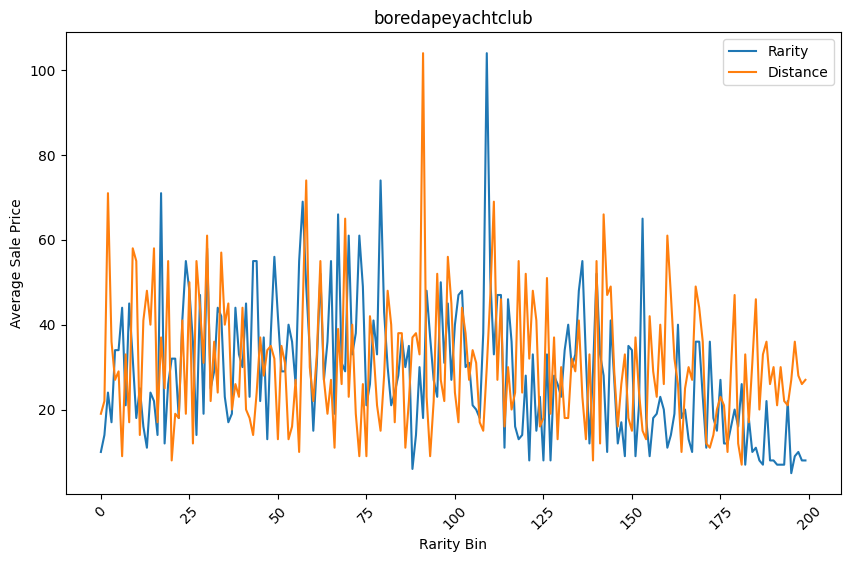

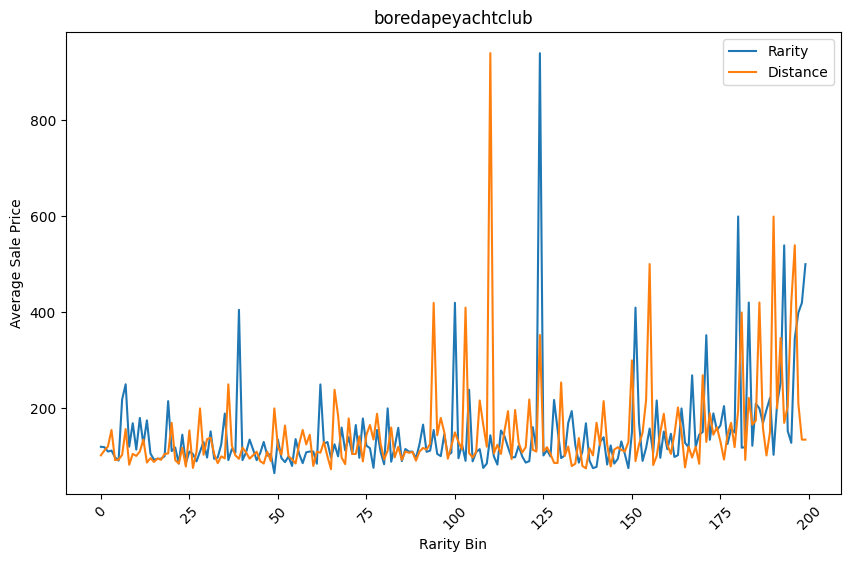

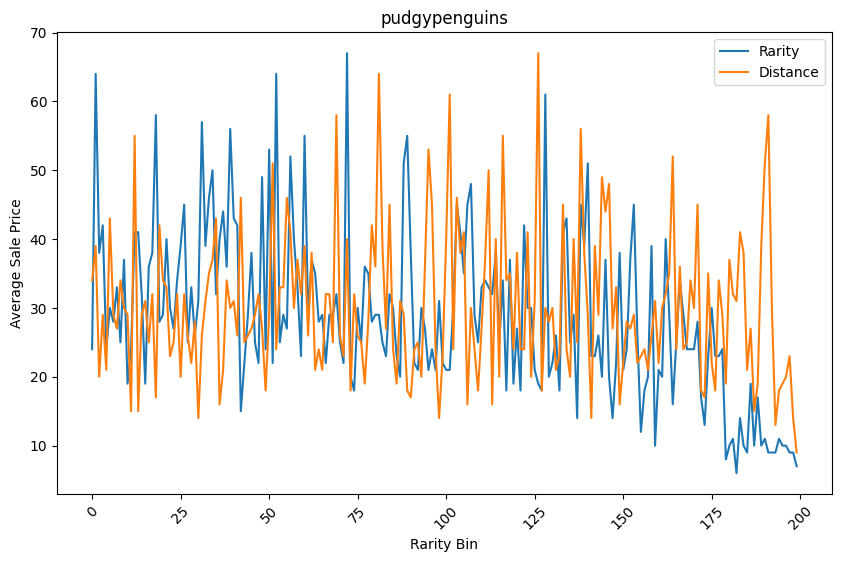

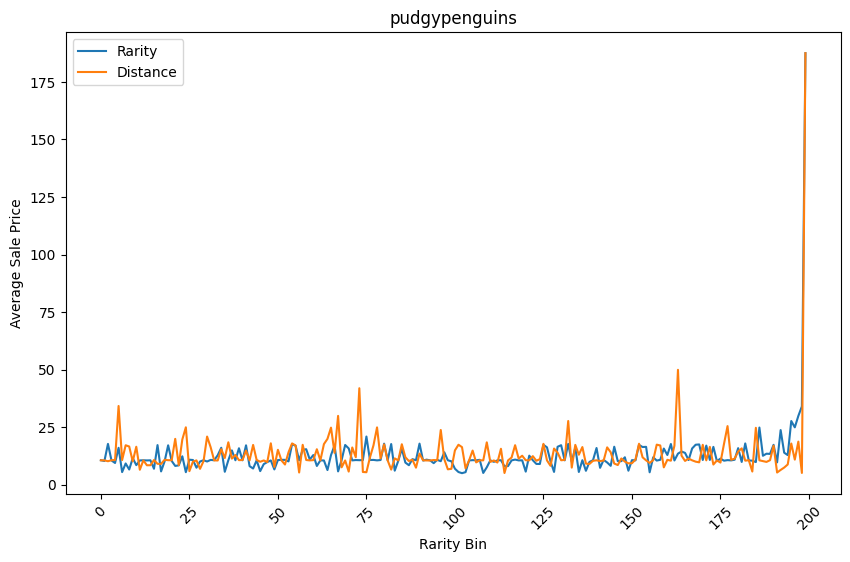

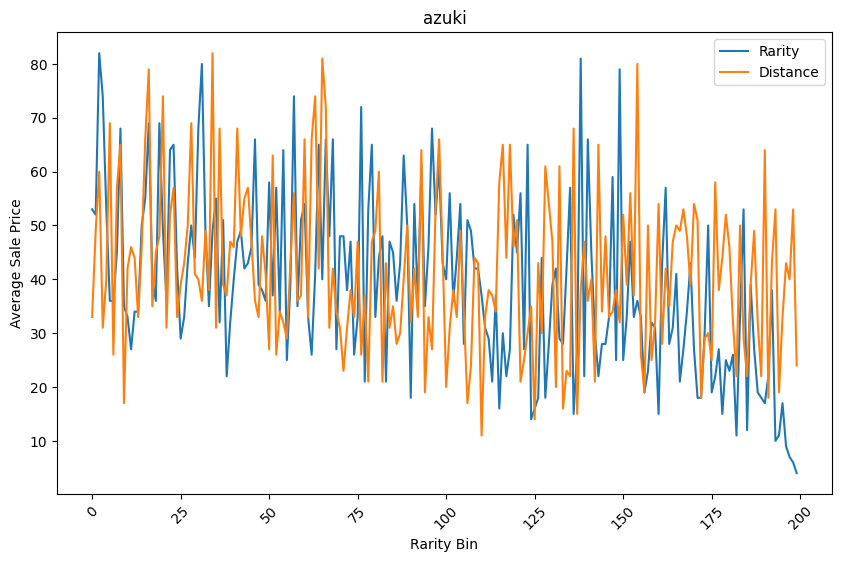

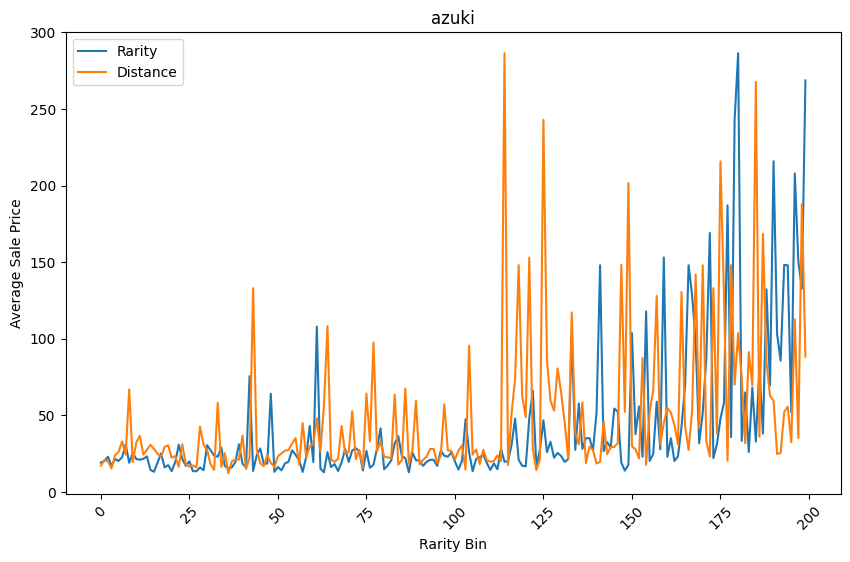

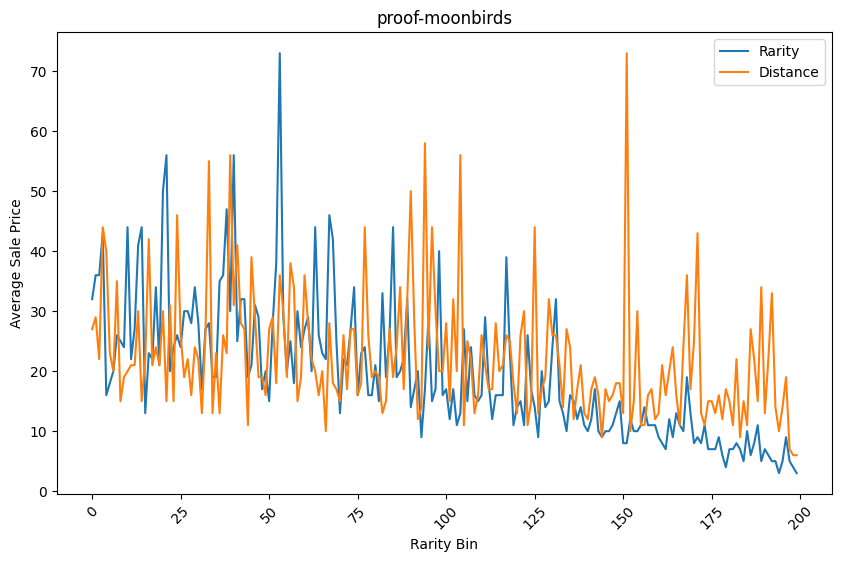

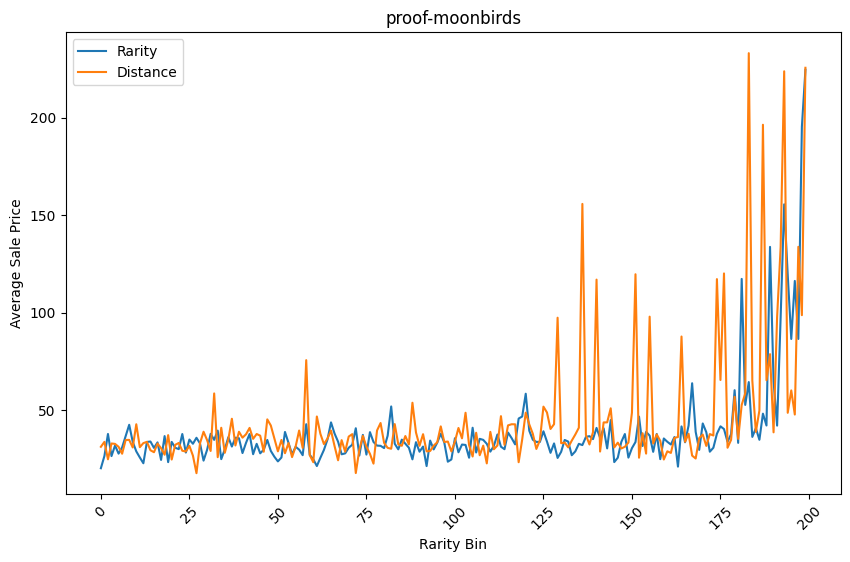

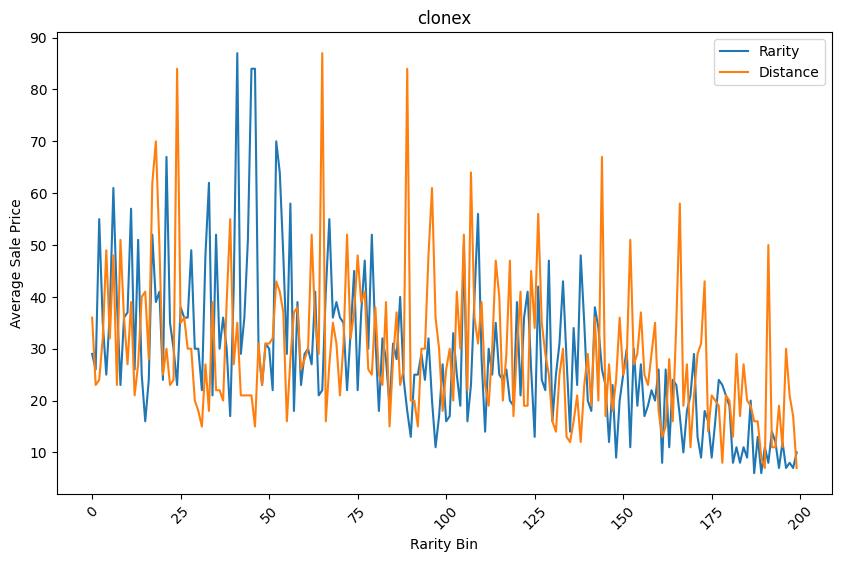

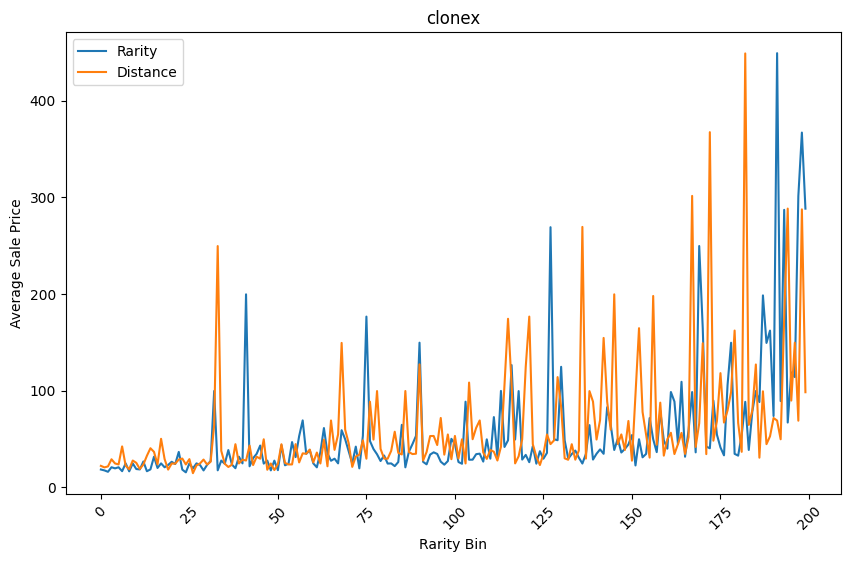

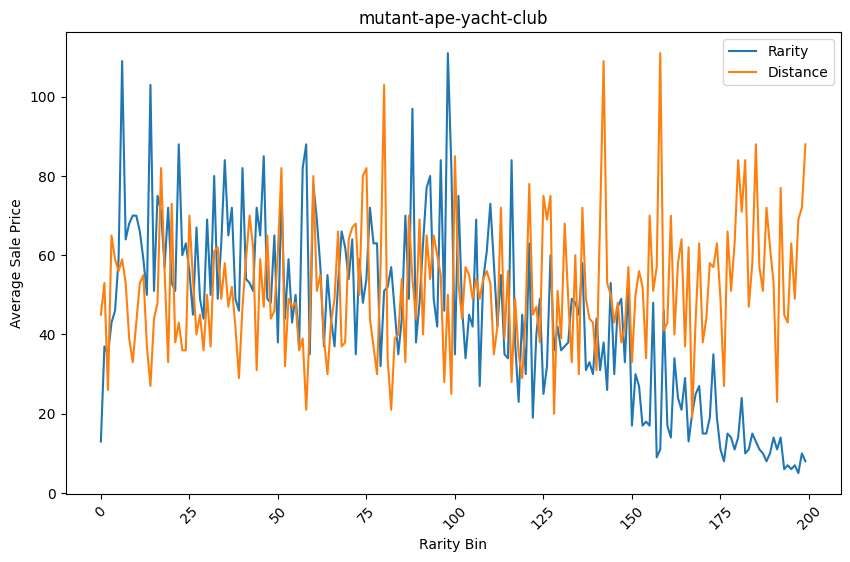

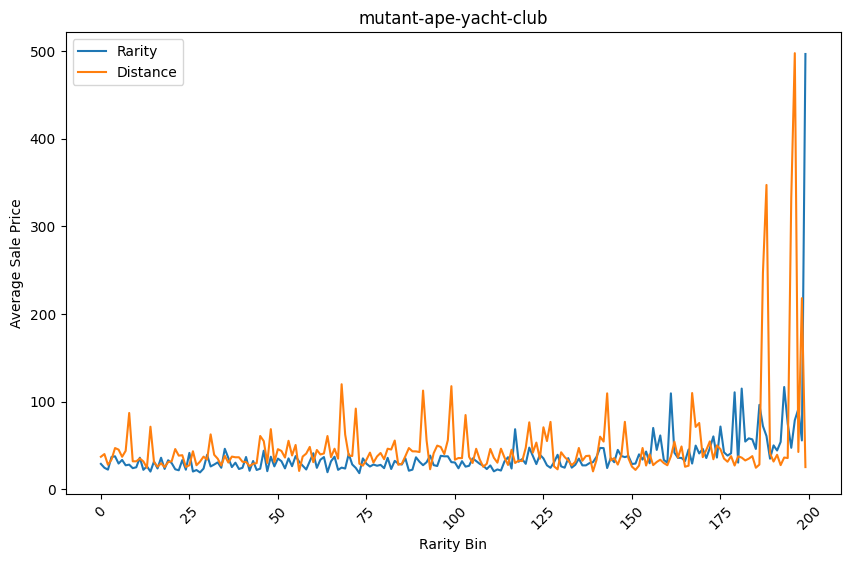

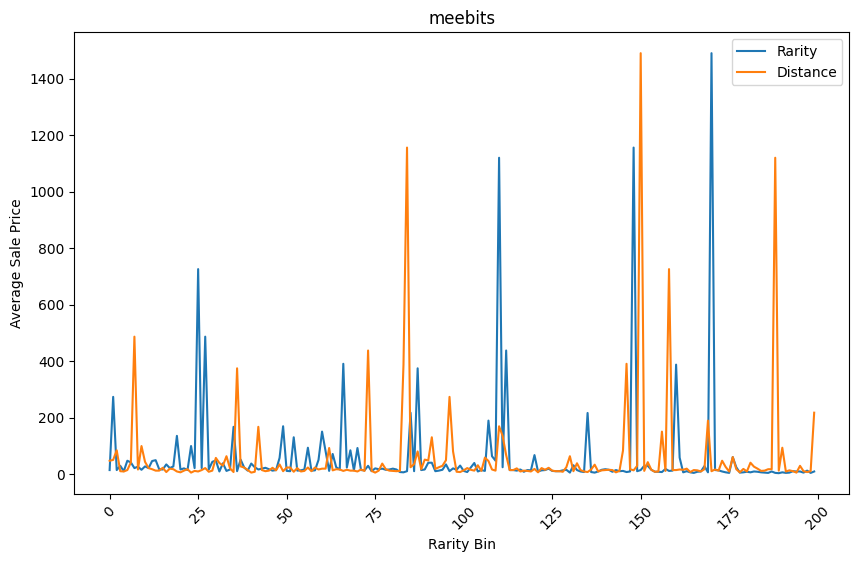

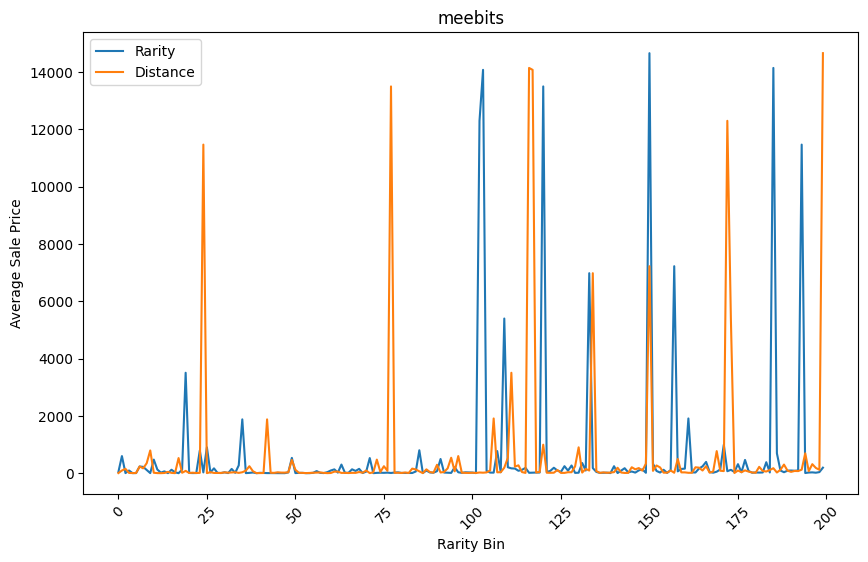

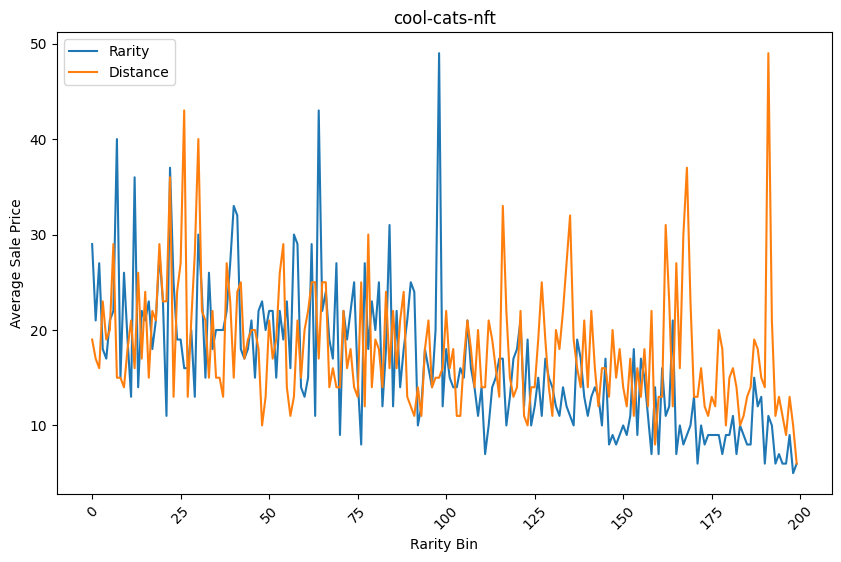

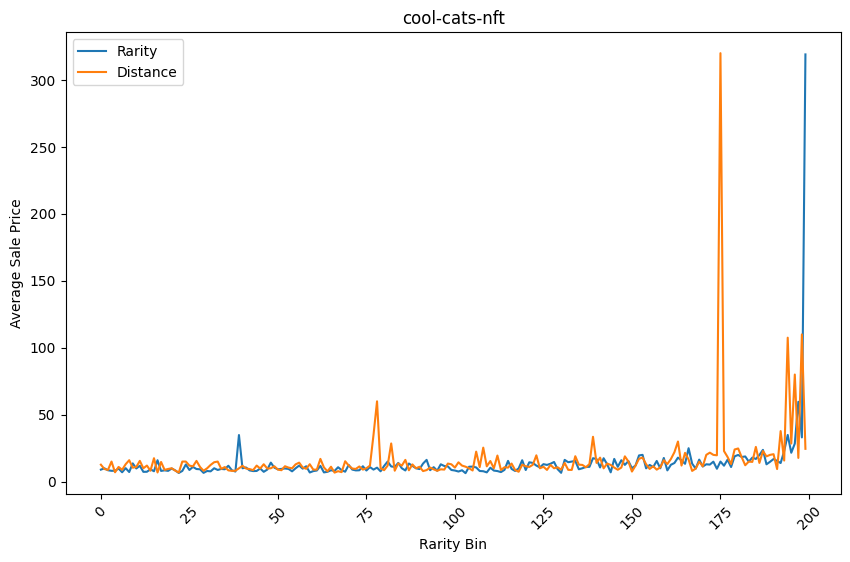

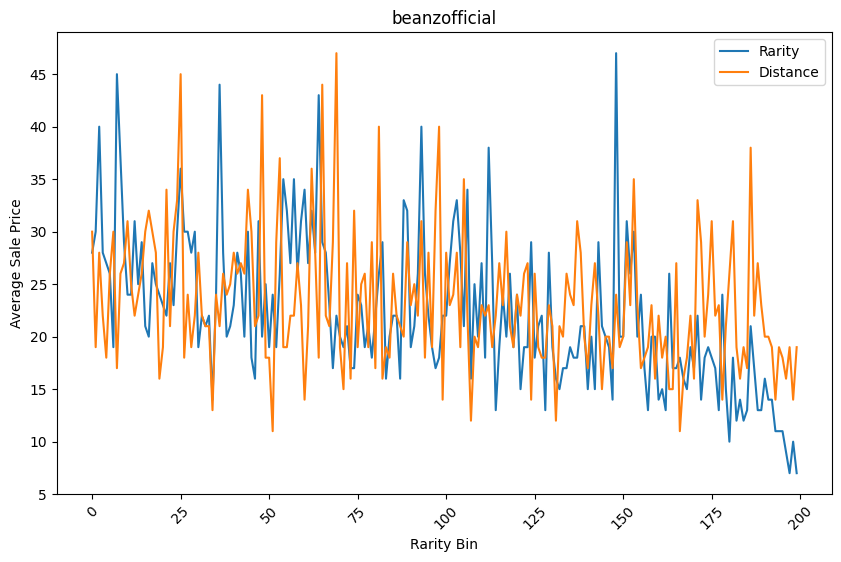

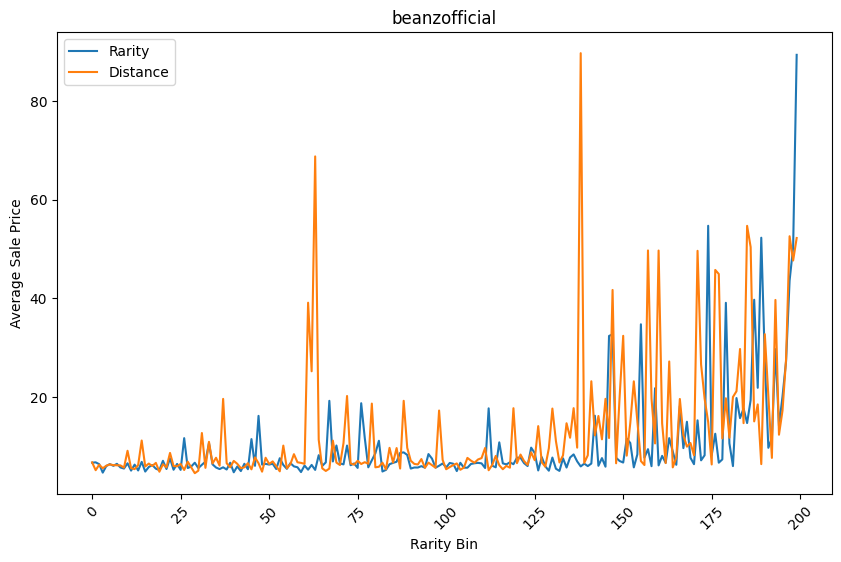

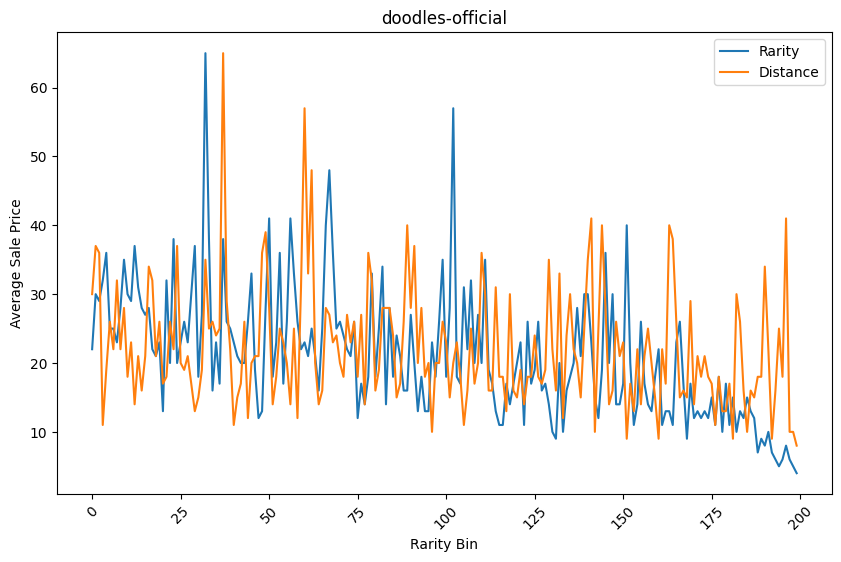

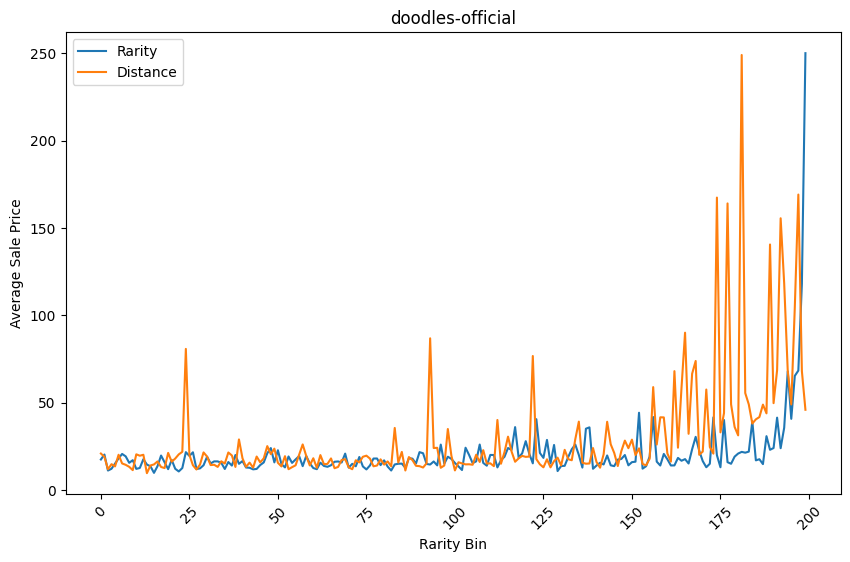

In [14]:
#NARUN COPY THIS CELL
df = snob.create_snob_df(img_path,feat_path,case_study=True,normalize=False)
df = snob.add_rarity_ranks_to_df(df)
slugs = df['Collection'].unique()
for slug in slugs:
    snob.plot_one_distance_and_rarity(df,slug,num_quants=200,y_axis='count',metric='maxmin')
    snob.plot_one_distance_and_rarity(df,slug,num_quants=200,y_axis='sale_price',metric='maxmin')

In [2]:
df = snob.create_snob_df(img_path,feat_path,case_study=True,normalize=False)
df = snob.add_rarity_ranks_to_df(df)
result_df = snob.make_case_study_result_df(df)

Dataset ReturnIndexDataset
    Number of datapoints: 137794
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/images_features/snob_case_study/val
slug           object
token_id        int64
sale_price    float64
count           int64
dtype: object


100%|██████████| 10/10 [00:01<00:00,  7.62it/s]


In [6]:
result_df = result_df.query("Slug!='meebits'")

In [14]:
result_df[['Slug','Rarity Correlation','Rarity Correlation (Count)','Filt Rarity Correlation']]
print(result_df.to_latex(columns=['Slug','Rarity Correlation','Rarity Correlation (Count)','Filt Rarity Correlation'],index=False))

\begin{tabular}{lrrr}
\toprule
Slug & Rarity Correlation & Rarity Correlation (Count) & Filt Rarity Correlation \\
\midrule
azuki & -0.170883 & 0.163149 & -0.114551 \\
beanzofficial & -0.165244 & 0.168878 & -0.082399 \\
boredapeyachtclub & -0.063194 & 0.111523 & -0.031122 \\
clonex & -0.183957 & 0.176747 & -0.136650 \\
cool-cats-nft & -0.148992 & 0.281166 & -0.097932 \\
doodles-official & -0.173598 & 0.177977 & -0.045757 \\
mutant-ape-yacht-club & -0.213170 & 0.209414 & -0.141859 \\
proof-moonbirds & -0.204417 & 0.266713 & -0.077283 \\
pudgypenguins & -0.073887 & 0.171108 & -0.020776 \\
\bottomrule
\end{tabular}



In [13]:
result_df[['Slug','Distance Correlation','Rarity Correlation','Filt Distance Correlation','Filt Rarity Correlation']]

,Slug,Distance Correlation,Rarity Correlation,Filt Distance Correlation,Filt Rarity Correlation
0,azuki,0.083666,-0.171019,0.083110,-0.114677
1,beanzofficial,0.126003,-0.165019,0.090412,-0.081768
2,boredapeyachtclub,0.066872,-0.063231,0.037243,-0.031166
3,clonex,0.130433,-0.183995,0.118145,-0.136888
4,cool-cats-nft,0.128112,-0.149079,0.066688,-0.098122
5,doodles-official,0.183056,-0.173612,0.075686,-0.045652
6,meebits,0.023720,-0.022201,0.015460,-0.019586
7,mutant-ape-yacht-club,0.012787,-0.213082,0.003412,-0.141679
8,proof-moonbirds,0.183972,-0.204715,0.064017,-0.077480
9,pudgypenguins,0.058517,-0.073870,0.004170,-0.020767
